In [1]:
from HeaderP import *
import Astraea
from sklearn import cluster, datasets, mixture
from sklearn.neighbors import kneighbors_graph
from sklearn.preprocessing import StandardScaler
from itertools import cycle, islice
import random

/Users/lucy/anaconda3/lib/python3.7/site-packages/sklearn/utils/__init__.py:4: DeprecationWarning: Using or importing the ABCs from 'collections' instead of from 'collections.abc' is deprecated, and in 3.8 it will stop working
  from collections import Sequence
/Users/lucy/anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_split.py:18: DeprecationWarning: Using or importing the ABCs from 'collections' instead of from 'collections.abc' is deprecated, and in 3.8 it will stop working
  from collections import Iterable
/Users/lucy/anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_search.py:16: DeprecationWarning: Using or importing the ABCs from 'collections' instead of from 'collections.abc' is deprecated, and in 3.8 it will stop working
  from collections import Mapping, namedtuple, defaultdict, Sequence
/Users/lucy/anaconda3/lib/python3.7/site-packages/sklearn/ensemble/weight_boosting.py:29: DeprecationWarning: numpy.core.umath_tests is an internal NumPy module 

In [29]:
mpf = 'aviary/data/metal_poor_avr.csv'
mrf = 'aviary/data/metal_rich_avr.csv'
af = 'aviary/data/all_stars_avr.csv'
def get_avr_coefficients():
    """
    Fit the parameters of the AVR using data from Yu & Liu:
    https://arxiv.org/pdf/1712.03965.pdf
    Fit to the relationship between log(sigma_z) and age.
    Returns:
        p_mp (array): coefficients [slope, intercept] for straight line fit to
            metal poor stars.
        p_mr (array): coefficients [slope, intercept] for straight line fit to
            metal rich stars.
        p_a (array): coefficients [slope, intercept] for straight line fit to
            all stars.
    """
    mp = pd.read_csv(mpf)
    mr = pd.read_csv(mrf)
    a = pd.read_csv(af)

    p_mp = np.polyfit(np.log(mp.sigma_z_kms), np.log(mp.Age_Gyr), 1)
    p_mr = np.polyfit(np.log(mr.sigma_z_kms), np.log(mr.Age_Gyr), 1)
    p_a = np.polyfit(np.log(a.sigma_z_kms), np.log(a.Age_Gyr), 1)

    return p_mp, p_mr, p_a

def v_to_age(v, coeffs):
    """
    Convert z velocity dispersion [km/s] to age [Gyr]
    Args:
        v (array): Z Velocity dispersion [km/s].
        coeffs (array): coefficients for straight line fit. [intercept, slope]
    Returns:
        age (array): age in Gyr.
    """
    b, a = coeffs
    logt = np.polyval(coeffs, np.log(v))
    return np.exp(logt)

def genErr(dv, dv_err):
    errorRand=np.random.normal(0, 1, len(dv))
    return dv+dv_err*errorRand

In [13]:
df_Prot_bin=pd.read_pickle('ProtVP_MS_150_w015_bin.pkl')
Vd_bins=pd.read_table('VD_bin',delimiter=',')
df_rvar=pd.read_pickle('Rvars.pkl')

df_Prot_bin=pd.merge(df_Prot_bin,Vd_bins,left_on='KID',right_on='KID',how='inner')
df_Prot_bin=pd.merge(df_Prot_bin,df_rvar,left_on='KID',right_on='KID',how='inner')

Text(0, 0.5, 'Rvar [ppm]')

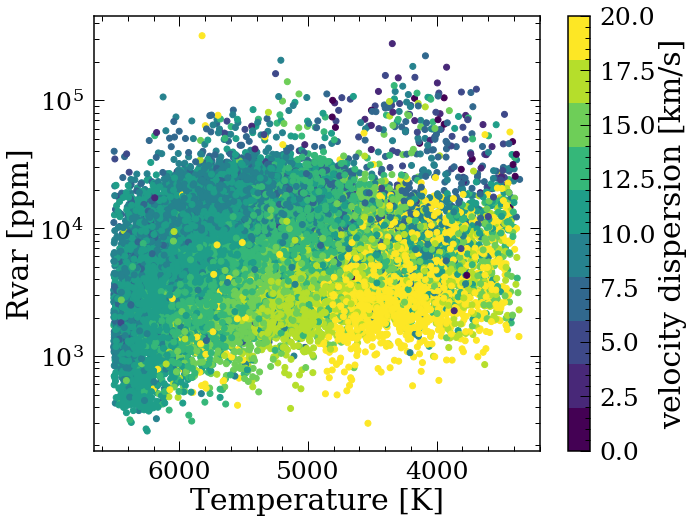

In [28]:
plt.figure(figsize=(10,8))
cm = plt.cm.get_cmap('viridis',10)
plt.scatter(df_Prot_bin['teff_calc'],df_Prot_bin['Rvar'],c=df_Prot_bin[' vd'],cmap=cm,vmin=0,vmax=20)
plt.gca().invert_xaxis()
plt.yscale('log')
cb=plt.colorbar()
cb.set_label('velocity dispersion [km/s]')
plt.xlabel('Temperature [K]')
plt.ylabel('Rvar [ppm]')

In [35]:
p_mp, p_mr, p_a = get_avr_coefficients()
df_Prot_bin['age']=v_to_age(df_Prot_bin[' vd'],p_mp)

BSt=np.zeros((len(df_Prot_bin),500))
for i in range(500):
    BSt[:,i]=genErr(df_Prot_bin[' vd'], df_Prot_bin[' vd_err'])

age_err=np.zeros(len(df_Prot_bin))
for i in range(len(df_Prot_bin)):
    age_err[i]=np.std(BSt[i,:])

df_Prot_bin['age_err']=age_err

Text(0, 0.5, 'Prot [days]')

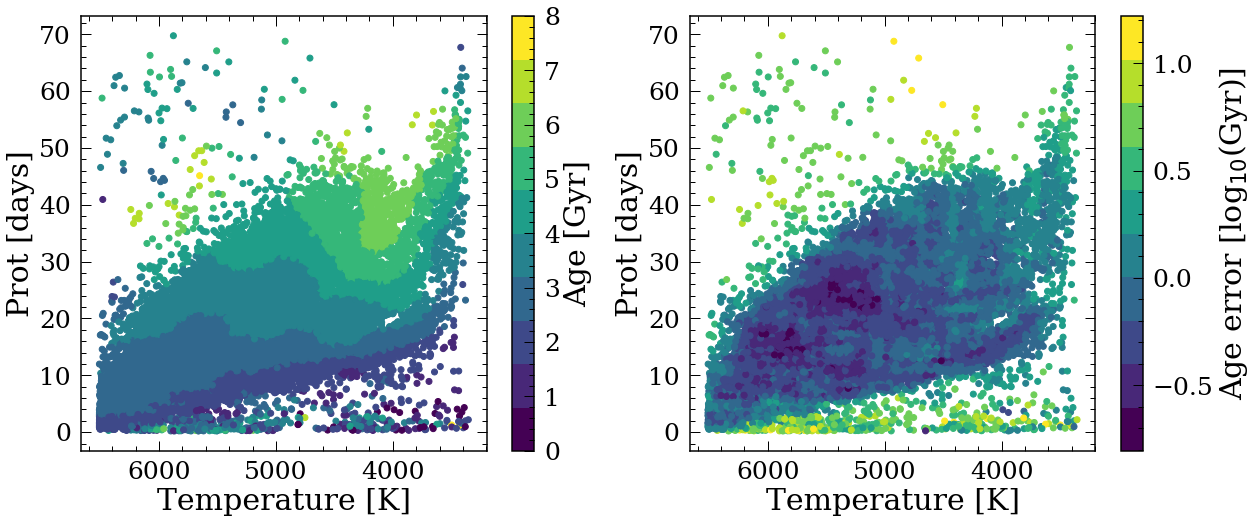

In [39]:
plt.figure(figsize=(20,8))
plt.subplot(1,2,1)
cm = plt.cm.get_cmap('viridis',10)
plt.scatter(df_Prot_bin['teff_calc'],df_Prot_bin['Prot'],c=df_Prot_bin['age'],cmap=cm,vmin=0,vmax=8)
plt.gca().invert_xaxis()
cb=plt.colorbar()
cb.set_label('Age [Gyr]')
plt.xlabel('Temperature [K]')
plt.ylabel('Prot [days]')

plt.subplot(1,2,2)
plt.scatter(df_Prot_bin['teff_calc'],df_Prot_bin['Prot'],c=np.log10(df_Prot_bin['age_err']),cmap=cm)
plt.gca().invert_xaxis()
cb=plt.colorbar()
cb.set_label('Age error [log$_{10}$(Gyr)]')
plt.xlabel('Temperature [K]')
plt.ylabel('Prot [days]')

In [41]:
df_Prot_bin.to_pickle('NewData/ProtVP_MS_150_w015_bin.pkl')

# Compare velocity disperison for Rvars and Prot

In [80]:
df_Rvar_bin=pd.read_pickle('NewData/RvarVP_MS_150_w015_NN_periods.pkl')

In [81]:
df_Rvar_bin['dv_Rvar']=df_Rvar_bin['dv_MAD']
df_Rvar_bin=df_Rvar_bin[['dv_Rvar','KID']]
df_Rvar_bin['age_Rvar']=v_to_age(df_Rvar_bin['dv_Rvar'],p_mp)
print(len(df_Rvar_bin))

89713


In [82]:
df_Prot_Rvar=pd.merge(df_Prot_bin,df_Rvar_bin,left_on='KID',right_on='KID')
df_Prot_Rvar['dv_Prot']=df_Prot_Rvar[' vd']
print(len(df_Prot_Rvar))

20471


Text(0, 0.5, 'Rvar Velocity Dispersion [km/s]')

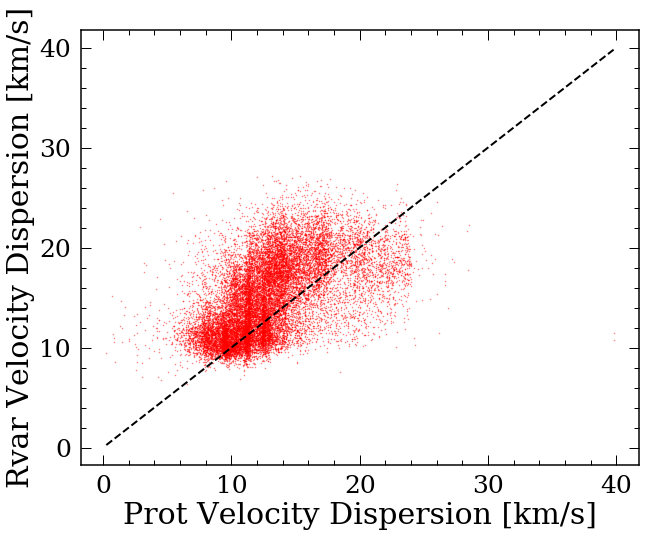

In [83]:
plt.figure(figsize=(10,8))
plt.plot(df_Prot_Rvar['dv_Prot'],df_Prot_Rvar['dv_Rvar'],'r.',markersize=1,alpha=0.5)
maxlim=max(max(df_Prot_Rvar['dv_Prot']),max(df_Prot_Rvar['dv_Rvar']))
minlim=min(min(df_Prot_Rvar['dv_Prot']),min(df_Prot_Rvar['dv_Rvar']))
plt.plot([minlim,maxlim],[minlim,maxlim],'k--')
plt.xlabel('Prot Velocity Dispersion [km/s]')
plt.ylabel('Rvar Velocity Dispersion [km/s]')

# use astraea to see if I can predict ages with Prot and Rvar

## Prot

In [91]:
df_Prot_bin=df_Prot_bin.dropna(subset=['Prot_log','teff_calc','age','age_err'])
regr, regr_outs = Astraea.RFregressor(df_Prot_bin, ['Prot_log','teff_calc'],
                                      target_var='age', target_var_err='age_err')


Simpliest example:
 regr,regr_outs = RFregressor(df,testF)

Fraction of data used to train: 0.8
# of Features attempt to train: 2
Features attempt to train: ['Prot_log', 'teff_calc']
21359 stars in dataframe!
21359 total stars used for RF!
17087 training stars!
Finished training! Making predictions!
Finished predicting! Calculating statistics!
Median Relative Error is: 0.002195047480564012
Average chi^2 is: 0.0040462265102343895
Finished!


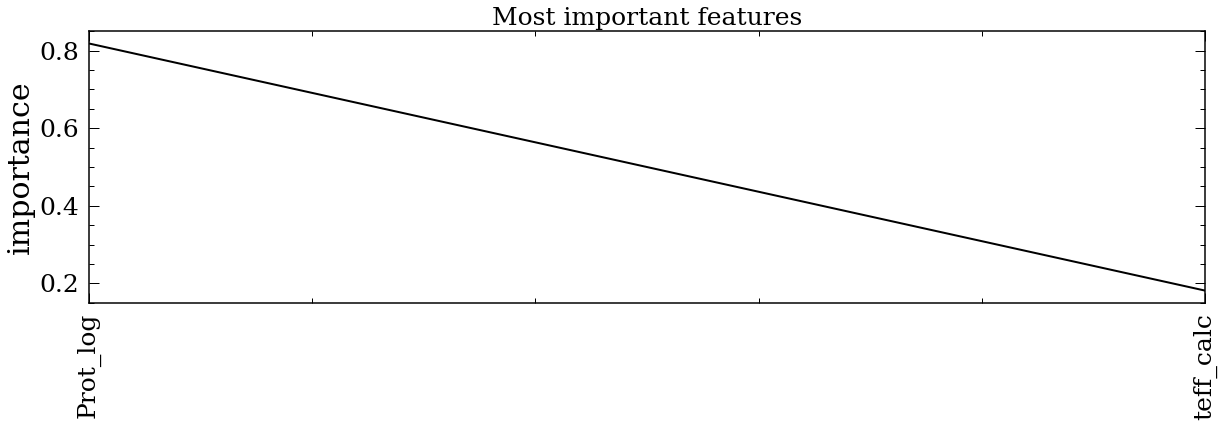

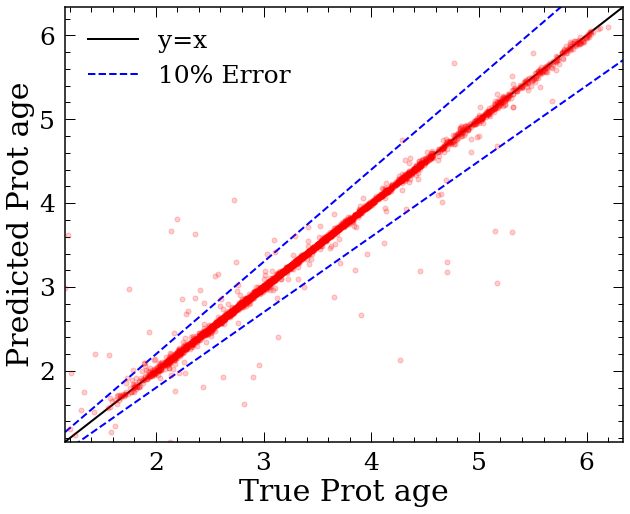

In [92]:
Astraea.plot_result(regr_outs['actrualF'], regr_outs['importance'], regr_outs['prediction'],
                    regr_outs['y_test'], labelName='Prot age', MS=10)

## Rvar

In [87]:
df_Prot_Rvar=df_Prot_Rvar.dropna(subset=['Rvar','teff_calc','age_Rvar'])
regr, regr_outs = Astraea.RFregressor(df_Prot_Rvar, ['Rvar','teff_calc'],
                                      target_var='age_Rvar', target_var_err='age_err')



Simpliest example:
 regr,regr_outs = RFregressor(df,testF)

Fraction of data used to train: 0.8
# of Features attempt to train: 2
Features attempt to train: ['Rvar', 'teff_calc']
20471 stars in dataframe!
20471 total stars used for RF!
16376 training stars!
Finished training! Making predictions!
Finished predicting! Calculating statistics!
Median Relative Error is: 0.028840690840979073
Average chi^2 is: 0.09573552747037128
Finished!


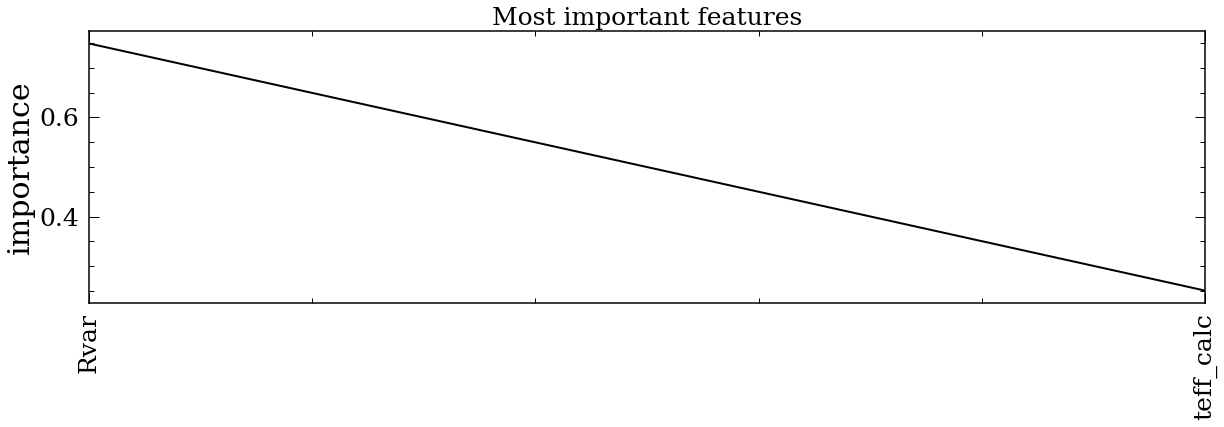

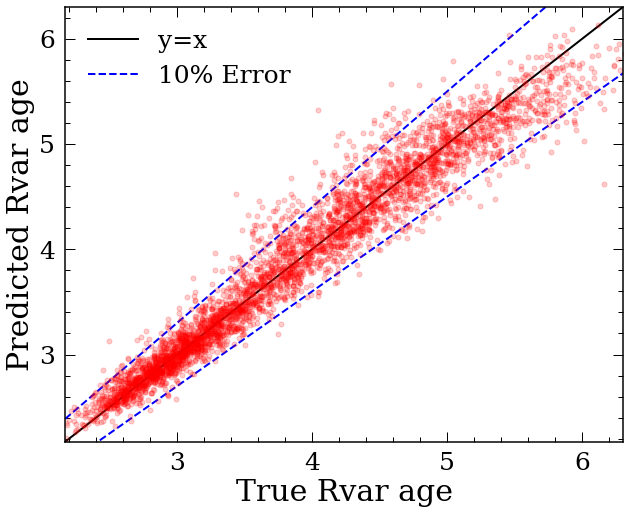

In [89]:
Astraea.plot_result(regr_outs['actrualF'], regr_outs['importance'], regr_outs['prediction'],
                    regr_outs['y_test'], labelName='Rvar age', MS=10)

## Rvar to Prot age

In [95]:
df_Prot_Rvar=df_Prot_Rvar.dropna(subset=['Rvar','teff_calc','age'])
regr, regr_outs = Astraea.RFregressor(df_Prot_Rvar, ['Rvar','teff_calc'],
                                      target_var='age', target_var_err='age_err')


Simpliest example:
 regr,regr_outs = RFregressor(df,testF)

Fraction of data used to train: 0.8
# of Features attempt to train: 2
Features attempt to train: ['Rvar', 'teff_calc']
20471 stars in dataframe!
20471 total stars used for RF!
16376 training stars!
Finished training! Making predictions!
Finished predicting! Calculating statistics!
Median Relative Error is: 0.09211145556384692
Average chi^2 is: 0.601097007046125
Finished!


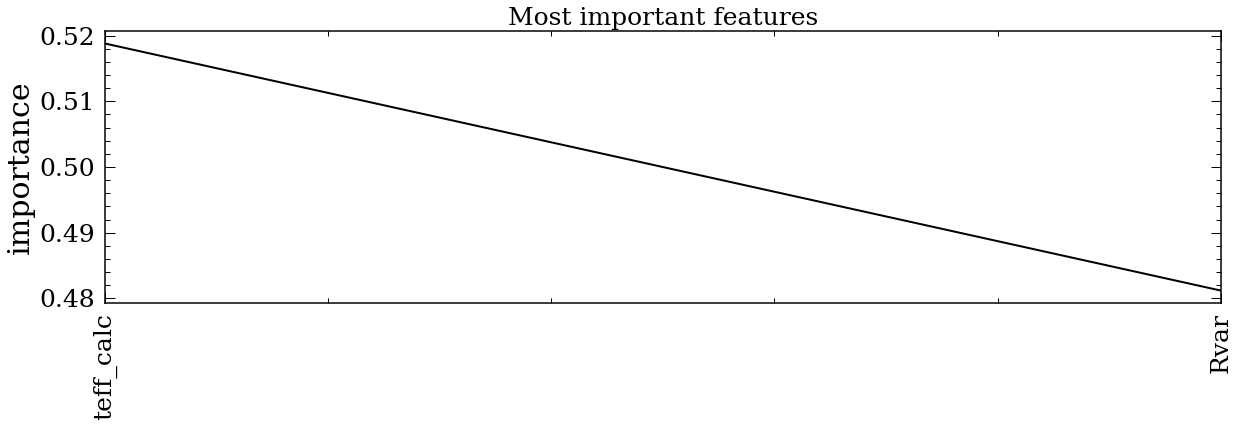

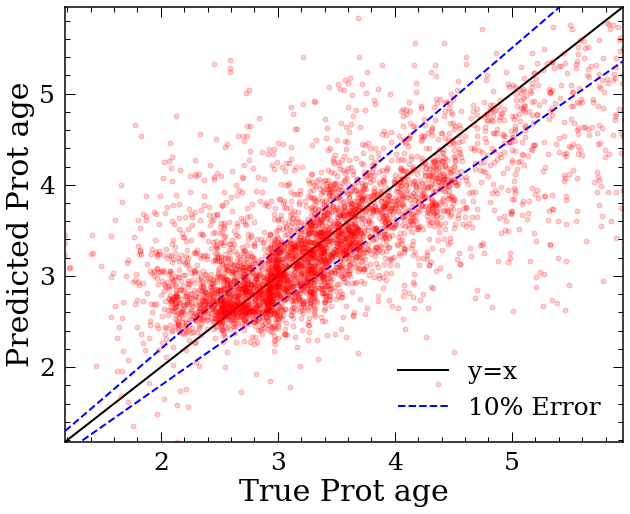

In [96]:
Astraea.plot_result(regr_outs['actrualF'], regr_outs['importance'], regr_outs['prediction'],
                    regr_outs['y_test'], labelName='Prot age', MS=10)

In [103]:
from astropy.table import Table
t = Table.from_pandas(df_Prot_Rvar)
t.write('Prot_Rvar.fits')